# TensorFlow on Textual Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
import collections
import re
import random
import sqlite3

---
# 1. Text Preproccessing

In [595]:
conn = sqlite3.connect('/Users/desiredewaele/Google Drive/Datasets/rawData.sqlite')
speeches = pd.read_sql("select date, president, text from Speeches where speech is 'Weekly Address'", conn)
speeches = speeches[speeches.president.str.contains('Barack Obama|William J. Clinton|George W. Bush', regex=True)]
speeches.reset_index(inplace=True, drop=True)
speeches.tail()

,date,president,text
1222,"December 31, 2016",Barack Obama,"Happy New Year, everybody. At a time when we t..."
1223,"December 10, 2016",Barack Obama,"Hi, everybody. It is the most wonderful time o..."
1224,"December 3, 2016",Barack Obama,"Hi, everybody. On the first day of my administ..."
1225,"January 7, 2017",Barack Obama,"Since the days of George Washington, President..."
1226,"January 14, 2017",Barack Obama,"This week, I traveled to Chicago to deliver my..."


In [596]:
def getDates(date):
    date = dt.datetime.strptime(date, '%B %d, %Y')
    date = dt.datetime.strftime(date, '%Y-%m-%d')
    return date

In [597]:
speeches.date = speeches.date.apply(getDates)
speeches.sort_values('date', inplace=True)
speeches.tail()

,date,president,text
1221,2016-12-17,Barack Obama,"Hi, everybody. If you've ever played a game of..."
1219,2016-12-24,Barack Obama,"The President. | Merry Christmas, everybody! ..."
1222,2016-12-31,Barack Obama,"Happy New Year, everybody. At a time when we t..."
1225,2017-01-07,Barack Obama,"Since the days of George Washington, President..."
1226,2017-01-14,Barack Obama,"This week, I traveled to Chicago to deliver my..."


In [598]:
def getSentences(text):
    sentences = np.array(re.split('\. |\! |\? |\; |\: |\" ', text))
    for i, s in enumerate(sentences):
        s = s.lower()                         # Change text to lowercase
        s = re.sub('\(\.*\)|\[\.*\]', '', s)  # Removes all bracket parts
        s = re.sub('[^(a-z)]| ', ' ', s)      # Change all not-text to spaces
        s = re.sub(' +',' ', s)               # Remove all redundant spaces
        s = s.strip()                         # Remove outer whitespace
        sentences[i] = s
    return sentences

In [599]:
sentences = pd.DataFrame(speeches.text.apply(getSentences).apply(pd.Series, 1).stack(), columns=['sentence'])
sentences.tail()

sentence
1226 26  it has been the honor of my life to serve you ...
     27  eight years later i am even more optimistic ab...
     28  and i look forward to working along your side ...
     29                                   thanks everybody
     30  god bless you and god bless the united states ...

In [600]:
indeces = sentences.index.get_level_values(0)
sentences['president'] = speeches.president[indeces].values
sentences['date'] = speeches.date[indeces].values

In [602]:
sentences.tail()

sentence     president  \
1226 26  it has been the honor of my life to serve you ...  Barack Obama   
     27  eight years later i am even more optimistic ab...  Barack Obama   
     28  and i look forward to working along your side ...  Barack Obama   
     29                                   thanks everybody  Barack Obama   
     30  god bless you and god bless the united states ...  Barack Obama   

               date  
1226 26  2017-01-14  
     27  2017-01-14  
     28  2017-01-14  
     29  2017-01-14  
     30  2017-01-14

---
# 2. Embedding with Word2Vec

---
## Build Dataset

In [9]:
words = sentences.sentence.str.split().values
words = np.array([item for sublist in words for item in sublist])

This function builds the dataset. 
* Counts stores the 3000 most occuring words with their number of occurences in a tuple.
* Dictionary stores the same words with their index in count.
* Reverse Dictionary swaps the key value pairs in dictionary.
* Data gets the index in dictionary for all words in the corpus.

In [10]:
def buildDataset(words, VOCAB=15000):
    
    # Count [['UNK', 52101], ('the', 43154), ('to', 33493) ...]
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(VOCAB - 1))
    
    # Dictionary {'UNK': 0, 'the': 1, 'to': 2, ...}
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # Reverse Dictionary {0: 'UNK', 1: 'the', 2: 'to', ...}
    rDictionary = dict(zip(dictionary.values(), dictionary.keys())) 

    # Data [61, 124, 13, 14, ...] Index in dictionary
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    
    return data, count, dictionary, rDictionary

In [11]:
data, count, dictionary, rDictionary = buildDataset(words)

In [12]:
print('Five most common words:', count[:5])
print('Five first words in texts:', words[:8])
print('Five first words count index:', data[:8])
del words

('Five most common words:', [['UNK', 595], (u'the', 43182), (u'to', 33498), (u'and', 32856), (u'of', 22917)])
('Five first words in texts:', array([u'hi', u'everybody', u'seven', u'years', u'ago', u'the',
       u'american', u'auto'], 
      dtype='<U25'))
('Five first words count index:', [614, 319, 1389, 59, 228, 1, 39, 1049])


---
## Generate Training Batches
The idea is to create word pairs of data and label words. Every word of the data set (or batch) is put together with a close occuring word in a tuple. Windows is the number of words to consider as a label left and right of the query word. Skips is the number of times we reuse a word to generate a label, so this should be two times the window.

<img src="skipgramdata.png" style="width: 600px;"/>

In [13]:
data_index = 0

def generateBatch(BATCH, SKIPS, WINDOW):
    global data_index
    assert BATCH % SKIPS == 0
    assert SKIPS <= 2 * WINDOW
    batch = np.ndarray(shape=(BATCH), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH, 1), dtype=np.int32)
    span = 2 * WINDOW + 1
    buffer = collections.deque(maxlen=span) # Create enhanced array
    for _ in range(span): # Add count index of every data word in span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(BATCH // SKIPS):
        target = WINDOW  # target label at the center of the buffer
        targets_to_avoid = [ WINDOW ]
        for j in range(SKIPS):
            while target in targets_to_avoid:
                target = np.random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * SKIPS + j] = buffer[WINDOW]
            labels[i * SKIPS + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [14]:
print('data:', [rDictionary[di] for di in data[:8]])

for SKIPS, WINDOW in [(4, 2), (2, 1)]:
    data_index = 0
    batch, labels = generateBatch(8, SKIPS, WINDOW)
    print('\nWith SKIPS = %d and WINDOW = %d:' % (SKIPS, WINDOW))
    print('    batch:', [rDictionary[bi] for bi in batch])
    print('    labels:', [rDictionary[li] for li in labels.reshape(8)])

('data:', [u'hi', u'everybody', u'seven', u'years', u'ago', u'the', u'american', u'auto'])

With SKIPS = 4 and WINDOW = 2:
('    batch:', [u'seven', u'seven', u'seven', u'seven', u'years', u'years', u'years', u'years'])
('    labels:', [u'ago', u'years', u'hi', u'everybody', u'seven', u'ago', u'the', u'everybody'])

With SKIPS = 2 and WINDOW = 1:
('    batch:', [u'everybody', u'everybody', u'seven', u'seven', u'years', u'years', u'ago', u'ago'])
('    labels:', [u'hi', u'seven', u'everybody', u'years', u'seven', u'ago', u'years', u'the'])


---
## Train Embeddings with Skip-Gram Model

In [15]:
BATCH = 200
EMBED = 128 # Dimension of the embedding vector.
WINDOW = 5 # How many words to consider left and right.
SKIPS = 10 # How many times to reuse an input to generate a label.
STEPS = 100001
VOCAB = 15000

In [16]:
# We pick a random validation set to sample nearest neighbors. Here we limit the validation samples 
# to the words that have a low numeric ID, which by construction are also the most frequent. 
valid_size = 5 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 20 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    tfTrainX = tf.placeholder(shape=[BATCH], dtype=tf.int32)
    tfTrainY = tf.placeholder(shape=[BATCH, 1], dtype=tf.int32)
    tfValidX = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # Embedding matrix, reducing vocab size to embed size
    embeddings = tf.Variable(tf.random_uniform([VOCAB, EMBED], -1.0, 1.0)) 
    weights = tf.Variable(tf.truncated_normal([VOCAB, EMBED], stddev=1.0 / np.sqrt(EMBED)))
    biases = tf.Variable(tf.zeros([VOCAB]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, tfTrainX) # Select embeddings for words in batch
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=weights, biases=biases, inputs=embed, 
        labels=tfTrainY, num_sampled=num_sampled, num_classes=VOCAB))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, tfValidX)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [17]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    average_loss = 0
    for step in range(STEPS):
        batchX, batchY = generateBatch(BATCH, SKIPS, WINDOW)
        _, l = session.run([optimizer, loss], {tfTrainX: batchX, tfTrainY: batchY})
        average_loss += l
        if step % 25000 == 0:
            if step > 0:
                average_loss /= 25000
            # The average loss is an estimate of the loss over the last 50000 batches.
            print('\nAverage loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = rDictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = rDictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()


Average loss at step 0: 5.312125
Nearest to must: cystic, mourns, manhattan, fahey, cancer, wronged, chose, amend,
Nearest to country: standing, resent, unlike, prosecuting, ballots, hiding, prairie, classified,
Nearest to your: prairies, basic, icy, kiddie, reagan, remembering, rodney, attainable,
Nearest to than: shelling, athens, fiscal, malia, nationality, forty, pages, plumbers,
Nearest to nation: avoidable, santa, melts, peers, waters, door, missouri, dramatic,

Average loss at step 25000: 3.003359
Nearest to must: can, will, should, ll, to, instruments, pills, buffett,
Nearest to country: nation, america, men, ranches, schoolbuses, world, people, children,
Nearest to your: you, healthy, models, ridiculous, advised, eligible, paralympics, fortitude,
Nearest to than: even, curfews, more, years, confiscate, losing, repay, standpoint,
Nearest to nation: country, america, world, conferred, constancy, straw, economy, grab,

Average loss at step 50000: 2.836178
Nearest to must: can, s

---
## Visualize Embeddings

In [18]:
def plotWithLabels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.savefig(filename)
    plt.show()

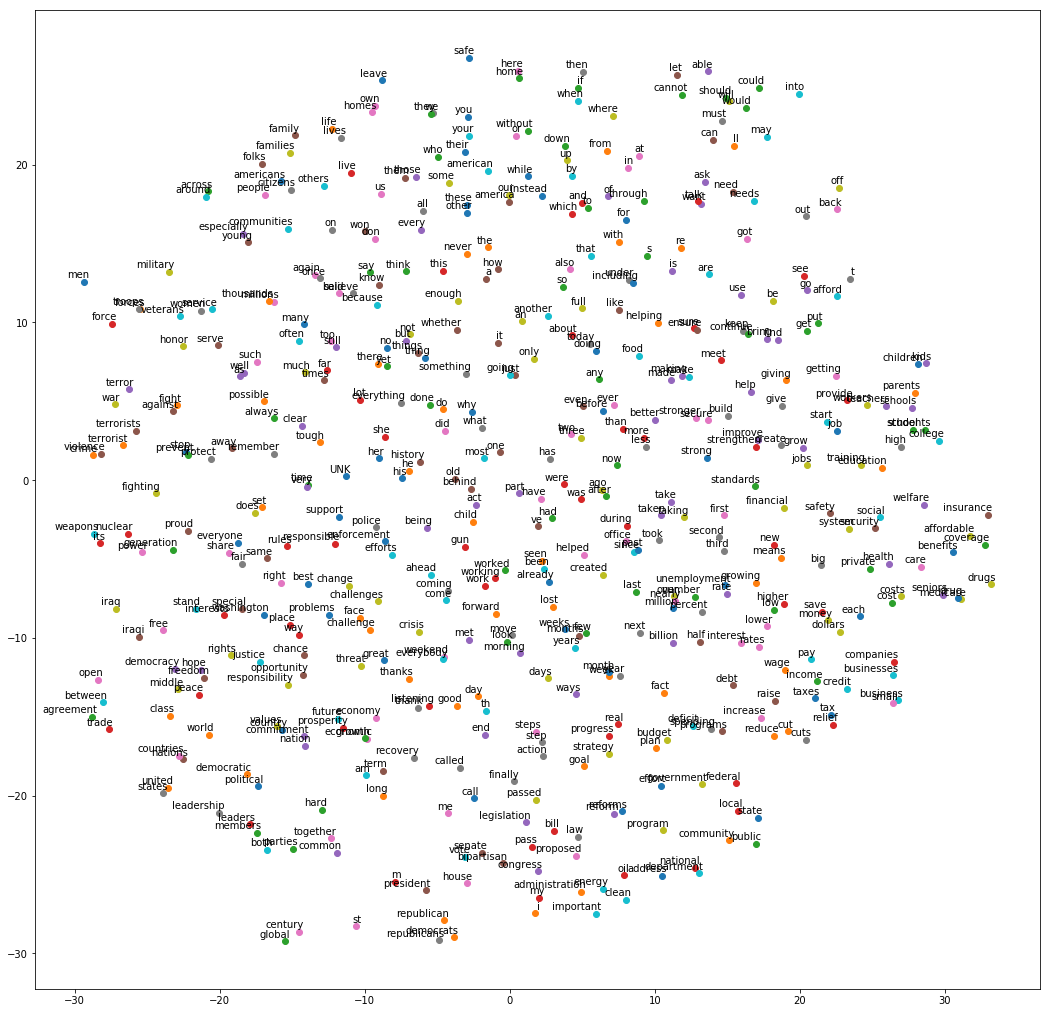

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[:500, :]) # Plot only 500
labels = [rDictionary[i] for i in xrange(500)]
plotWithLabels(low_dim_embs, labels)

---
# 3. Classify Texts with Embeddings

---
## Sentence Embed IDs

In [603]:
sentences.tail()

sentence     president  \
1226 26  it has been the honor of my life to serve you ...  Barack Obama   
     27  eight years later i am even more optimistic ab...  Barack Obama   
     28  and i look forward to working along your side ...  Barack Obama   
     29                                   thanks everybody  Barack Obama   
     30  god bless you and god bless the united states ...  Barack Obama   

               date  
1226 26  2017-01-14  
     27  2017-01-14  
     28  2017-01-14  
     29  2017-01-14  
     30  2017-01-14

In [604]:
TEXT = max(sentences.sentence.apply(lambda x: len(x.split())))
print 'The longest sentence contains {} words.'.format(TEXT)

The longest sentence contains 114 words.


In [605]:
def getEmbed(words):
    ids = np.empty(words.size, int)
    for i, word in enumerate(words):
        ids[i] = dictionary[word] if word in dictionary else 0
    return ids
    
def pad(text):
    words = np.array(text.split())
    ids = getEmbed(words)
    pad = np.zeros(TEXT - len(words), int)
    return np.append(ids, pad)

In [606]:
data = pd.DataFrame(sentences.sentence.apply(pad).tolist(), index=sentences.index)
print data.shape
data.tail()

(49077, 114)


0     1    2    3    4     5    6     7    8    9   ...   104  105  \
1226 26    15    37   79    1  428     4   73   201    2  415 ...     0    0   
     27  1820    59  813   11  359   125   23  2286   63    8 ...     0    0   
     28     3    11  412  261    2    93  804    99  925   24 ...     0    0   
     29   141   319    0    0    0     0    0     0    0    0 ...     0    0   
     30   541  1195   30    3  541  1195    1   161  117    4 ...     0    0   

         106  107  108  109  110  111  112  113  
1226 26    0    0    0    0    0    0    0    0  
     27    0    0    0    0    0    0    0    0  
     28    0    0    0    0    0    0    0    0  
     29    0    0    0    0    0    0    0    0  
     30    0    0    0    0    0    0    0    0  

[5 rows x 114 columns]

In [607]:
labels = sentences.president
labels.tail()

1226  26    Barack Obama
      27    Barack Obama
      28    Barack Obama
      29    Barack Obama
      30    Barack Obama
Name: president, dtype: object

---
## Data Preparation

In [608]:
print('Training set', data.shape, labels.shape)

('Training set', (49077, 114), (49077,))


One-hot encoding of labels.

In [612]:
labels = pd.get_dummies(labels)
labels.tail()

Barack Obama  George W. Bush  William J. Clinton
1226 26             1               0                   0
     27             1               0                   0
     28             1               0                   0
     29             1               0                   0
     30             1               0                   0

In [613]:
print('Training set', data.shape, labels.shape)

('Training set', (49077, 114), (49077, 3))


Training, validation and testing split.

In [614]:
indeces = range(len(speeches))
np.random.shuffle(indeces)

In [615]:
trainX = data.loc[indeces[:800]].sample(frac=1, random_state=1)
validX = data.loc[indeces[800:1000]].sample(frac=1, random_state=1)
testX = data.loc[indeces[1000:]].sample(frac=1, random_state=1)

trainY = labels.loc[indeces[:800]].sample(frac=1, random_state=1)
validY = labels.loc[indeces[800:1000]].sample(frac=1, random_state=1)
testY = labels.loc[indeces[1000:]].sample(frac=1, random_state=1)

In [616]:
#from sklearn.model_selection import train_test_split
#trainValidX, testX, trainValidY, testY = train_test_split(data, labels, test_size=10000, random_state=100)
#trainX, validX, trainY, validY = train_test_split(trainValidX, trainValidY, test_size=10000, random_state=100)

In [617]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)
print('Testing set:', testX.shape, testY.shape)

('Training set:', (32079, 114), (32079, 3))
('Validation set:', (8015, 114), (8015, 3))
('Testing set:', (8983, 114), (8983, 3))


---
## Convolutional Neural Network to Classify Sentences

<img src="TextCNN.png" style="width: 900px;"/>

In [620]:
# Hyperparameters
BATCH = 100
LABELS = 3
CHANNELS = 1
FILTERSIZES = [4, 5, 6]
FILTERS = 128
RATE = 1e-2
DROPOUT = 0.6
L2 = 1
STEPS = 3001
BREAKS = 30

In [621]:
print 'All Embedings ({}, {})'.format(VOCAB, EMBED)
print 'Batch Embedings ({}, {}, {}, {})'.format(BATCH, TEXT, EMBED, CHANNELS)
print 'Filters ({}, {}, {}, {})'.format(FILTERSIZES, EMBED, CHANNELS, FILTERS)
print 'Conv Scores ({}, {}, {}, {})'.format(BATCH, TEXT - FILTERSIZES + 1, 1, FILTERS)
print 'Max Pools ({}, {})'.format(BATCH, len(FILTERSIZES) * FILTERS)
print 'Logits ({}, {})'.format(BATCH, LABELS)

All Embedings (15000, 128)
Batch Embedings (100, 114, 128, 1)
Filters ([4, 5, 6], 128, 1, 128)
Conv Scores (100, [111 110 109], 1, 128)
Max Pools (100, 384)
Logits (100, 3)


In [628]:
graph = tf.Graph()
with graph.as_default():
        
    # Placeholders for input, output and dropout
    tfDataX = tf.placeholder(tf.int32, shape=[None, TEXT])
    tfDataY = tf.placeholder(tf.float32, shape=[None, LABELS])
    tfDrop = tf.placeholder(tf.float32)
    
    # Gather relevant embeddings
    # w = tf.Variable(tf.random_uniform([VOCAB, EMBED], -1.0, 1.0))
    embeddings = tf.nn.embedding_lookup(final_embeddings, tfDataX)
    embeddings = tf.expand_dims(embeddings, -1)
    l2Loss = tf.constant(0.0)

    pooled_outputs = []
    for filterSize in FILTERSIZES:
        
        # Convolutional Variables
        weights = tf.Variable(tf.truncated_normal([filterSize, EMBED, 1, FILTERS], stddev=0.1))
        bias = tf.Variable(tf.constant(0.1, shape=[FILTERS]))
        
        # Convolution Layer
        x = tf.nn.conv2d(embeddings, weights, strides=[1, 1, 1, 1], padding="VALID")
        x = tf.nn.relu(tf.nn.bias_add(x, bias))

        # Max-pooling over the outputs
        pooled = tf.nn.max_pool(x, ksize=[1, TEXT - filterSize + 1, 1, 1], strides=[1, 1, 1, 1], padding='VALID')
        pooled_outputs.append(pooled)

    # Combine all pooled features
    totalFilters = FILTERS * len(FILTERSIZES)
    x = tf.concat(pooled_outputs, axis=3)
    x = tf.reshape(x, [-1, totalFilters])

    # Add dropout
    x = tf.nn.dropout(x, tfDrop)

    # Affine Layer
    weights = tf.Variable(tf.truncated_normal([totalFilters, LABELS], stddev=0.1))
    bias = tf.Variable(tf.constant(0.1, shape=[LABELS]))
    l2Loss += tf.nn.l2_loss(weights) + tf.nn.l2_loss(bias)
    logits = tf.nn.xw_plus_b(x, weights, bias)

    # Calculate mean cross-entropy loss
    globalStep = tf.Variable(initial_value=0, trainable=False)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY)) + L2*l2Loss
    optimizer = tf.train.AdamOptimizer(RATE)
    gradients = optimizer.compute_gradients(loss)
    training = optimizer.apply_gradients(gradients, global_step=globalStep)

    # Calculate Accuracy
    predictions = {"classes": tf.argmax(logits, 1), "probabilities": tf.nn.softmax(logits)}
    correctPredictions = tf.equal(predictions['classes'], tf.argmax(tfDataY, 1))
    accuracy = tf.reduce_mean(tf.cast(correctPredictions, "float"))

In [629]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("{:>8} {:>16} {:>20} {:>20}".format('Time', 'Step', 'Loss Train Valid', 'Acc Train Valid'))    
    for step in range(STEPS):
        offset = (step * BATCH) % (len(trainX) - BATCH)
        batchX = trainX.values[offset:(offset + BATCH), :]
        batchY = trainY.values[offset:(offset + BATCH), :]
        trainFeed = {tfDataX: batchX, tfDataY: batchY, tfDrop: DROPOUT}
        _, globalstep, trainLoss, trainAcc = session.run([training, globalStep, loss, accuracy], trainFeed)
        if(step % (STEPS // BREAKS) == 0):
            validFeed = {tfDataX: validX, tfDataY: validY, tfDrop: 1}
            validLoss, validAcc = session.run([loss, accuracy], validFeed)
            print("{:%H:%M:%S} {g:>8} of {s:>4} {tl:>14.2f}, {vl:>1.2f} {ta:>14.2f}, {va:>1.2f}".format(
                dt.datetime.now(), g=globalstep, s=STEPS, tl=trainLoss, vl=validLoss, ta=trainAcc, va=validAcc))
    testFeed = {tfDataX: testX, tfDataY: testY, tfDrop: 1}
    testLoss, testAcc, testPred = session.run([loss, accuracy, predictions], testFeed)
    print("\nTest Loss & Acc: {tl:>1.2f}, {ta:>1.2f}".format(tl=testLoss, ta=testAcc))

    Time             Step     Loss Train Valid      Acc Train Valid
13:50:24        1 of 3001           5.60, 6.49           0.32, 0.38
13:51:00      101 of 3001           1.11, 1.08           0.34, 0.47


KeyboardInterrupt: 

---
## Sentence Voting to Classify Texts

Probabilities per sentence.

In [561]:
sentenceProbs = pd.DataFrame(testPred['probabilities'], index=testY.index).sort_index()
sentenceProbs.head()

0         1         2
6 0  0.999799  0.000051  0.000149
  1  0.650876  0.237313  0.111810
  2  0.048667  0.636573  0.314759
  3  0.716772  0.025570  0.257658
  4  0.828107  0.012506  0.159387

Probabilities per text.

In [557]:
textProbs = sentenceProbs.groupby(level=0).mean()
textProbs.head()

,0,1,2
6,0.494354,0.130504,0.375142
19,0.612334,0.090352,0.297314
21,0.440088,0.192666,0.367246
28,0.675228,0.058777,0.265994
31,0.506342,0.126030,0.367628


Compare classes and labels per text

In [558]:
textClasses = np.argmax(textProbs.values, axis=1)

In [559]:
sentenceLabels = pd.Series(np.argmax(testY.values, 1), index=testY.index)
textLabels = sentenceLabels.groupby(level=0).max()

In [619]:
np.mean(textClasses == textLabels)

0.908675799086758